In [ ]:

%pip -q install gtbook # also installs latest gtsam pre-release

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
# Save the factor graph as a Graphviz DOT file
# gtsam.gtsam.writeG2o(graph, optimized_values, "factor_graph12.dot")


Factor Graph:
NonlinearFactorGraph: size: 379

Factor 0: PriorFactor on 0
  prior mean:  (288, 192, 0)
  noise model: diagonal sigmas [10; 10; 0.174532925];

Factor 1: BetweenFactor(0,1)
  measured:  (156.126975, 6.36839996, -2.86340834)
  noise model: constrained sigmas [0; 0; 0];
  noise model: constrained mu [1000; 1000; 1000];

Factor 2: BetweenFactor(0,2)
  measured:  (375.545526, -107.096713, 0.0128560326)
  noise model: constrained sigmas [0; 0; 0];
  noise model: constrained mu [1000; 1000; 1000];

Factor 3: BetweenFactor(0,3)
  measured:  (131.682274, 1260.1726, -0.360637339)
  noise model: constrained sigmas [0; 0; 0];
  noise model: constrained mu [1000; 1000; 1000];

Factor 4: BetweenFactor(0,4)
  measured:  (-155.239394, -133.117619, -0.0671374631)
  noise model: constrained sigmas [0; 0; 0];
  noise model: constrained mu [1000; 1000; 1000];

Factor 5: BetweenFactor(0,5)
  measured:  (26.9788017, -126.418502, 0.017921322)
  noise model: constrained sigmas [0; 0; 0];
  noi

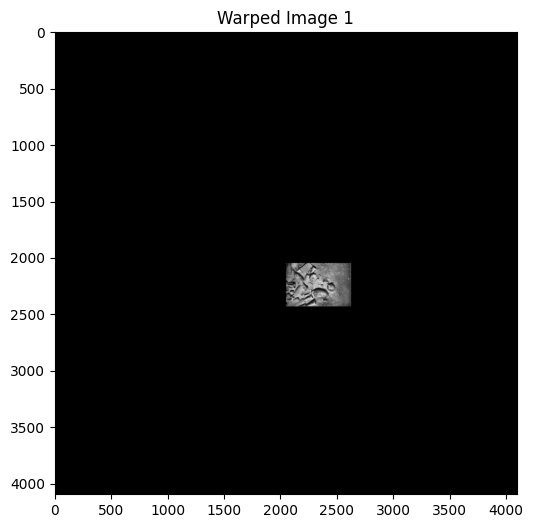

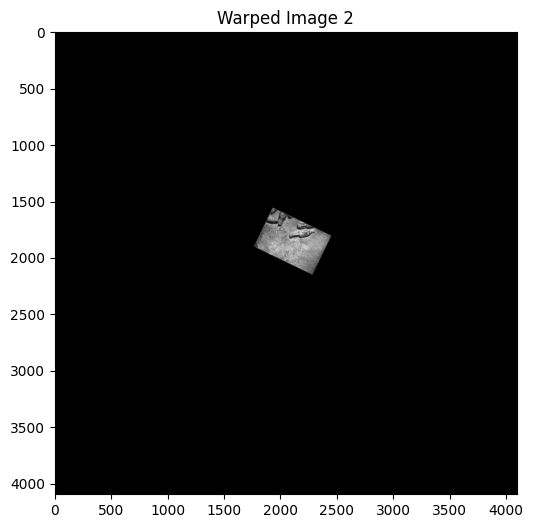

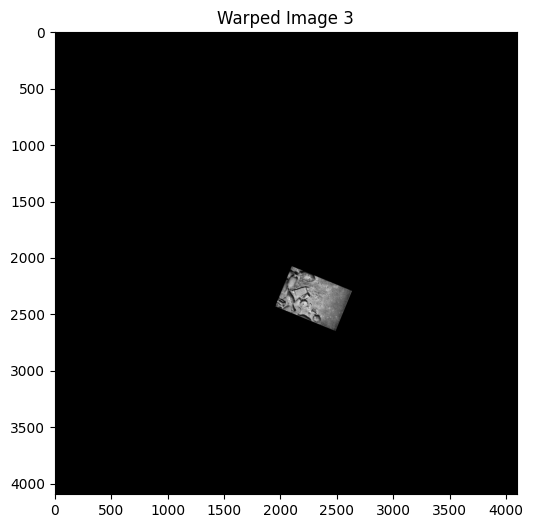

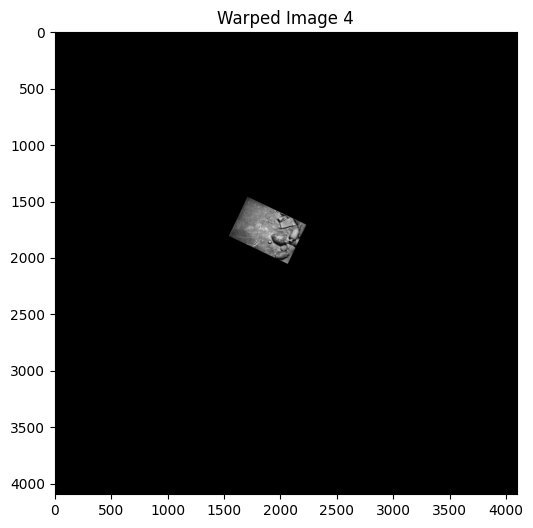

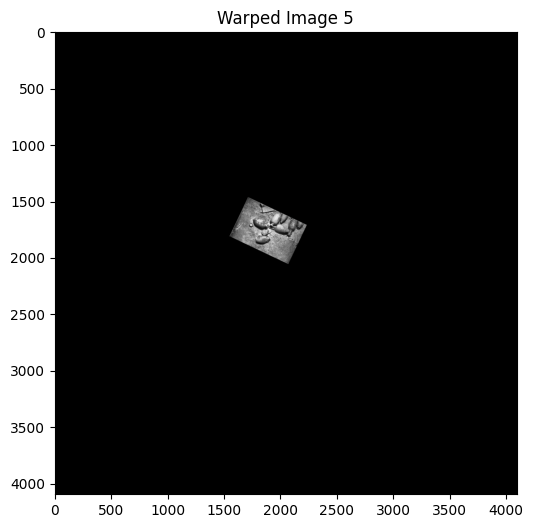

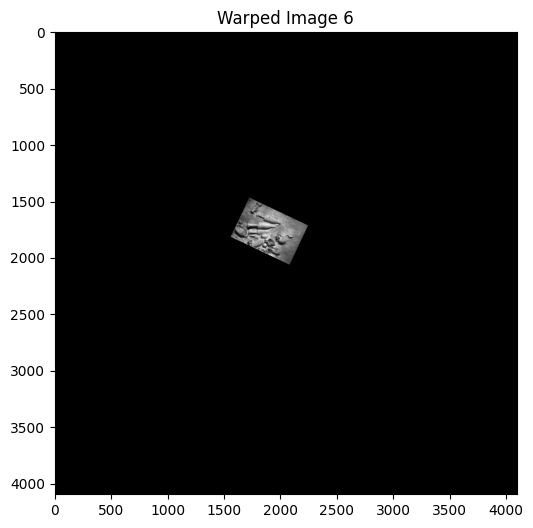

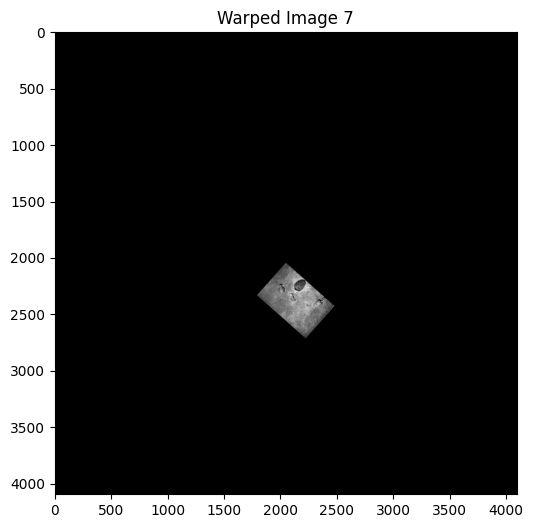

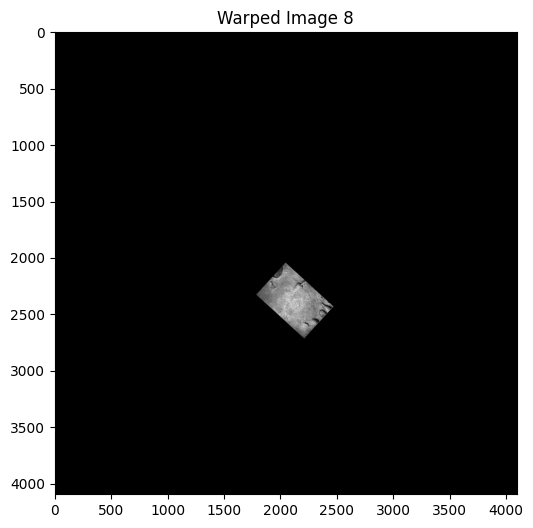

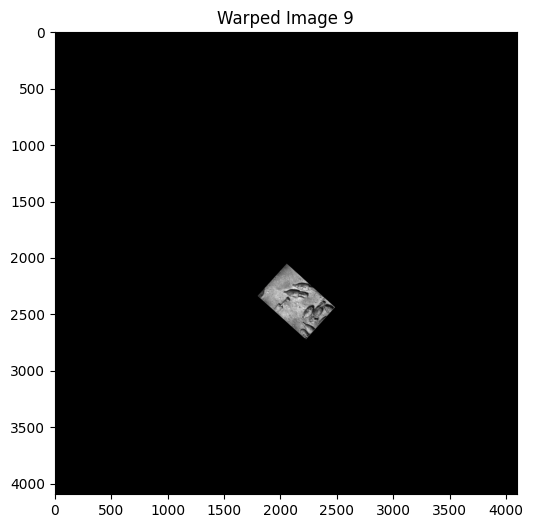

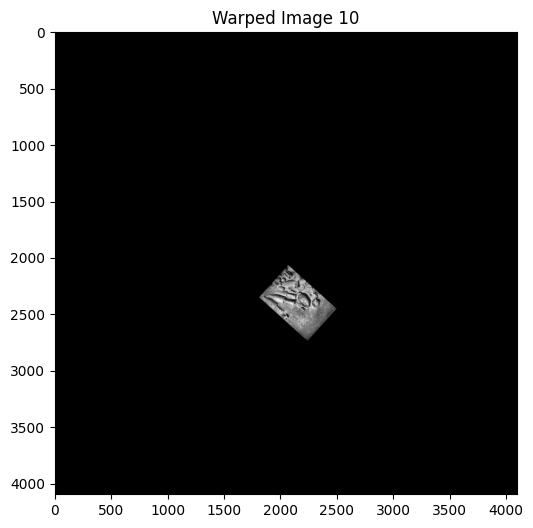

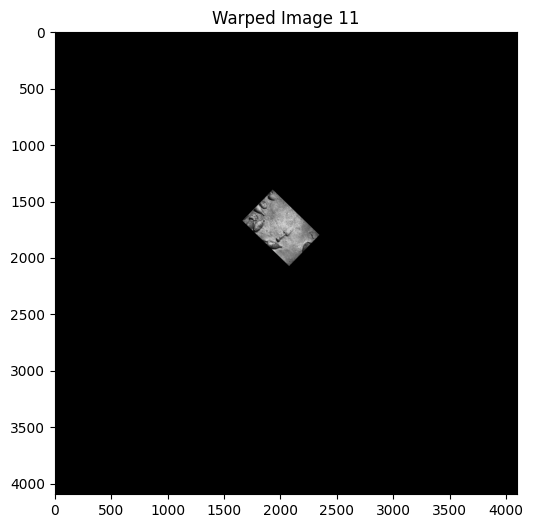

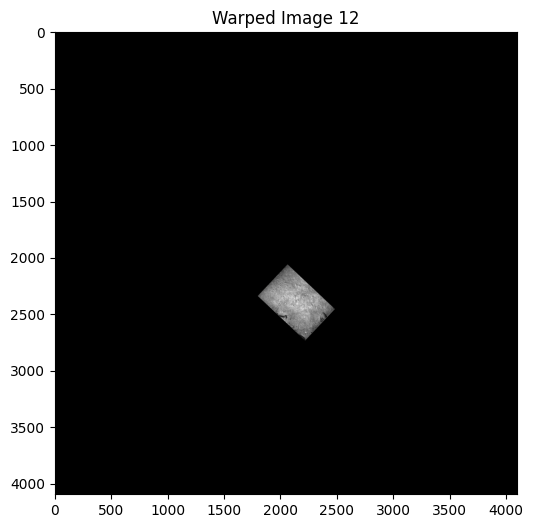

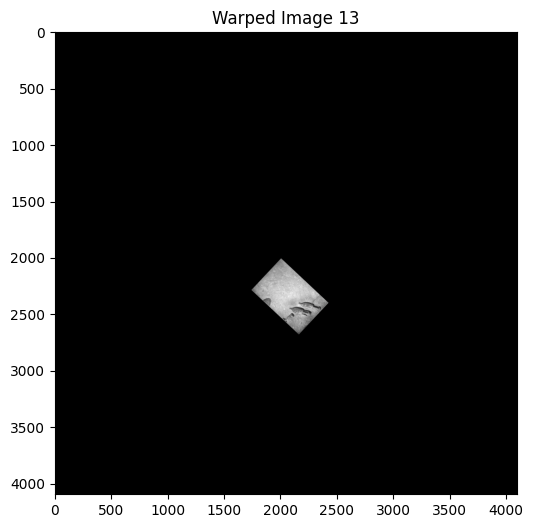

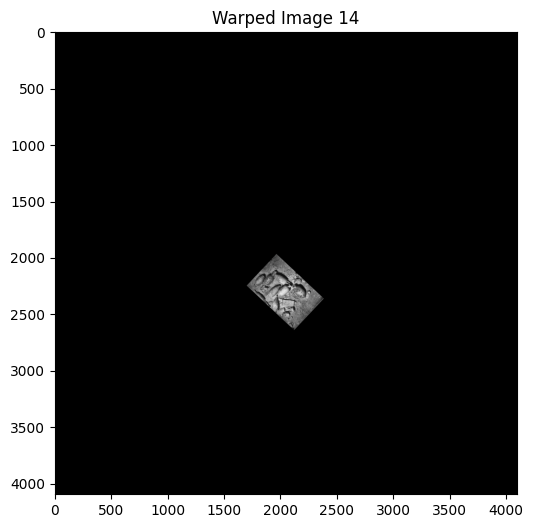

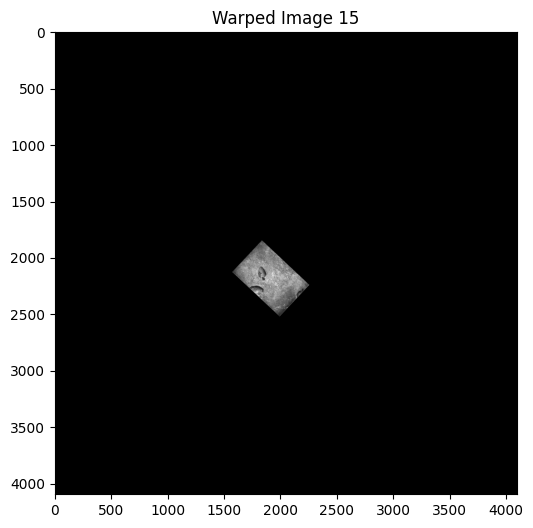

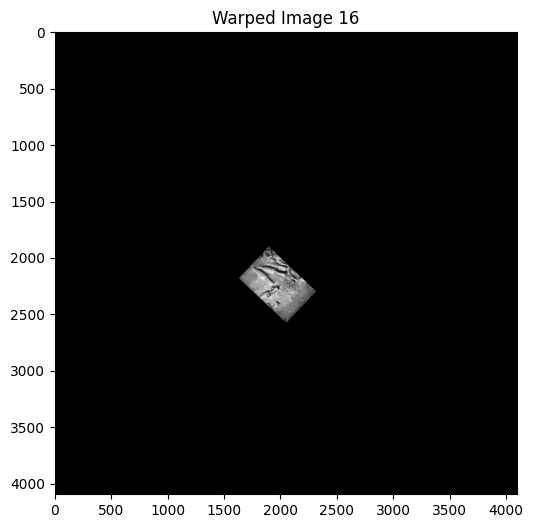

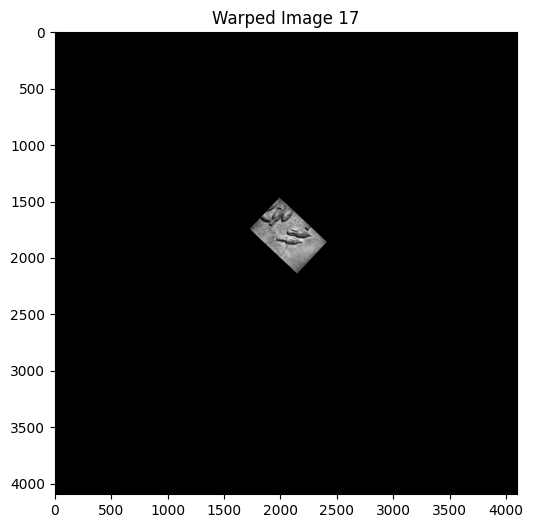

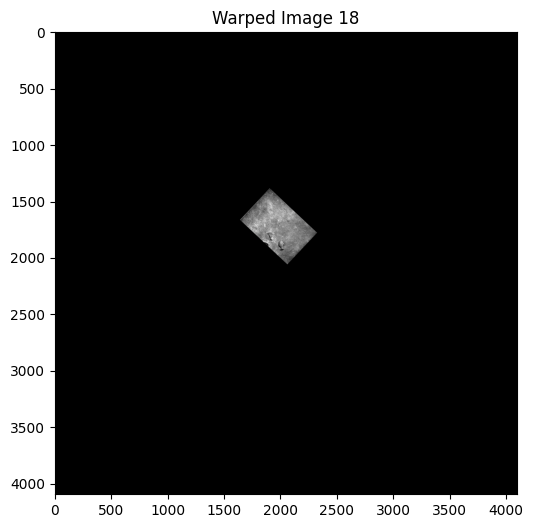

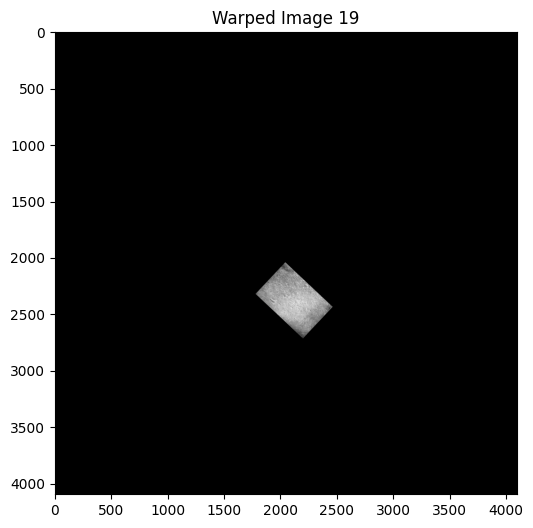

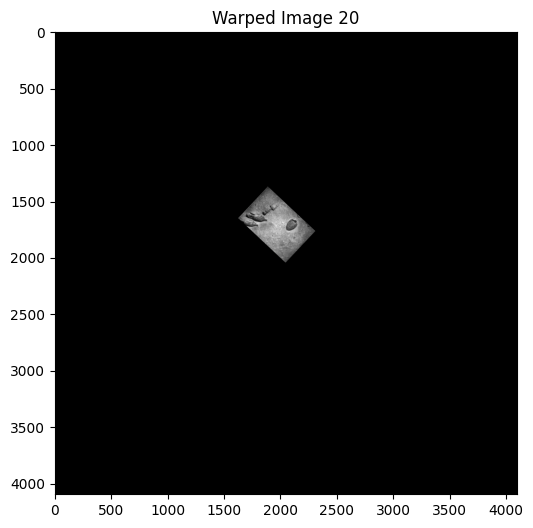

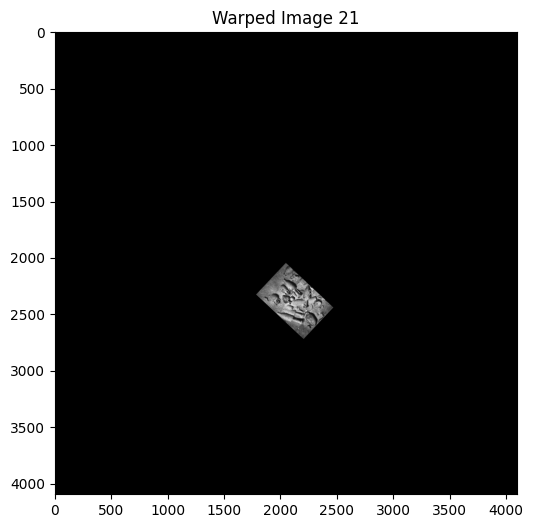

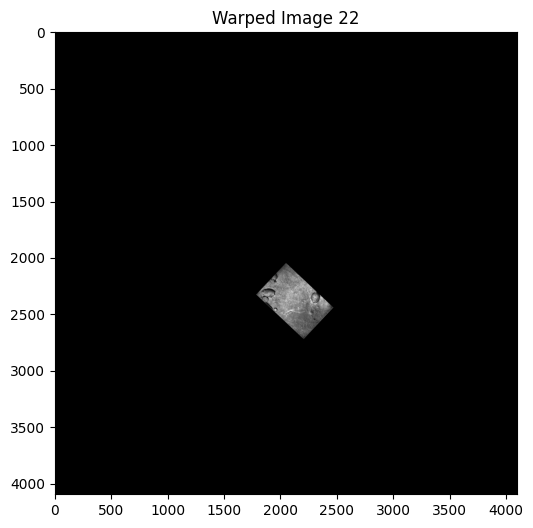

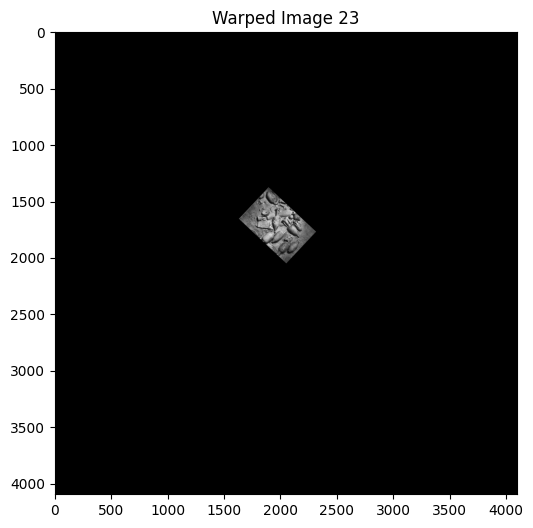

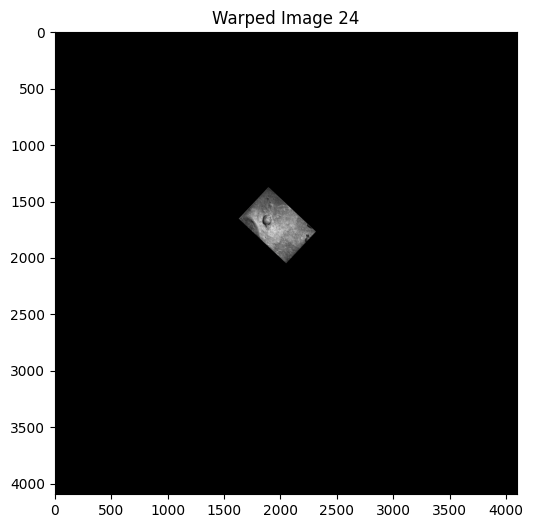

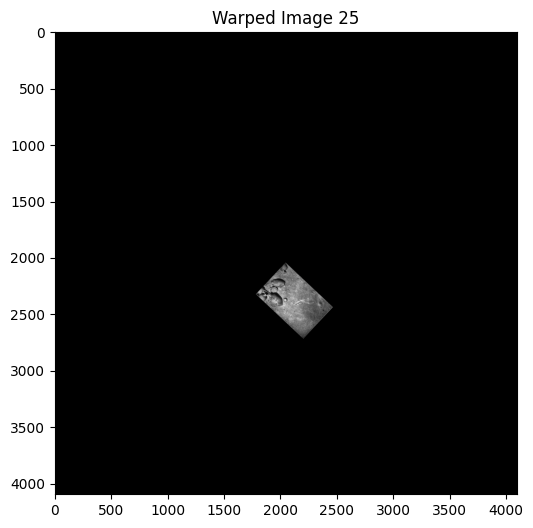

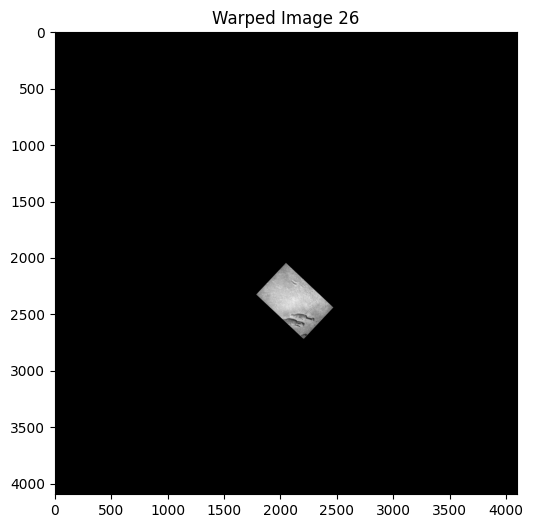

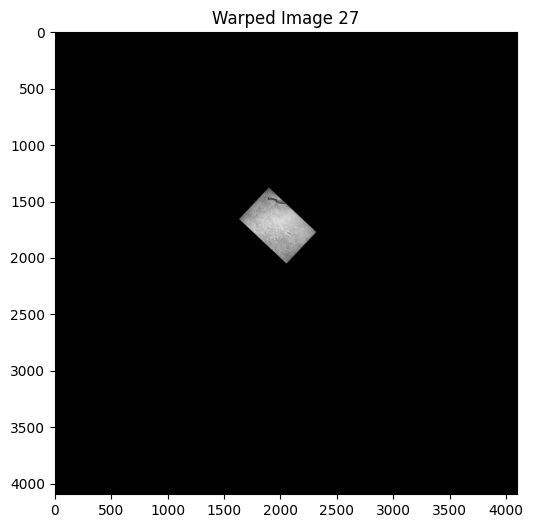

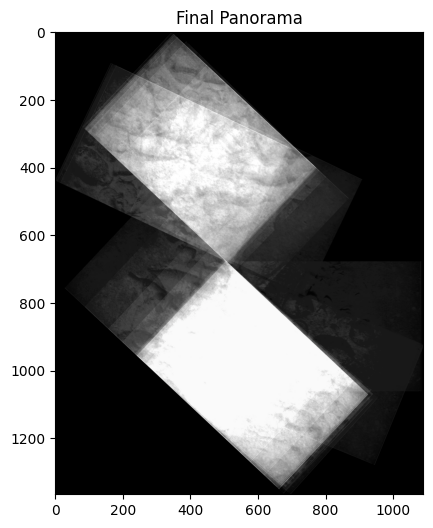

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gtsam
import itertools
import math
import gtsam.utils.plot as gtsam_plot

# Folder containing image pairs
image_folder = 'Images/29Images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.tif', '.bmp'))]

# Sort the image files to ensure they are in the correct order
# image_files.sort()

# Initialize an empty list to store the loaded and normalized images
images = []

# Initialize CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Load and enhance each image file individually
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    image = cv2.imread(img_path)

    # Apply CLAHE for local contrast enhancement
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_channel = clahe.apply(l_channel)
    enhanced_lab_image = cv2.merge((l_channel, a_channel, b_channel))
    enhanced_image = cv2.cvtColor(enhanced_lab_image, cv2.COLOR_LAB2BGR)

    images.append(enhanced_image)


# Initialize empty canvases for the left panorama
height, width, _ = images[0].shape
# panorama_size = (width * 2, height * len(images))
panorama_size = (4096, 4096)

# Initialize blank canvas for the final panorama
stitched_panorama = np.zeros((panorama_size[1], panorama_size[0], 3), np.uint8)

# Initialize an identity matrix as the cumulative homography matrix
cumulative_homography = np.eye(3)

# Initialize translation matrix
translation = np.array([[1, 0, panorama_size[0] / 2], [0, 1, panorama_size[1] / 2], [0, 0, 1]])

# Initialize updated homographies list
updated_homographies = []
# Initialize lists to store keypoints and descriptors for each image
keypoints_list = []
descriptors_list = []

# Create a SIFT detector
sift = cv2.SIFT_create(nfeatures=4000, nOctaveLayers=12, contrastThreshold=0.025, sigma=1.5)

# Initialize a list to store the number of keypoints before and after RANSAC
keypoints_before_ransac = []
keypoints_after_ransac = []

# Initialize a list to store the number of matches before and after RANSAC
matches_before_ransac = []
matches_after_ransac = []

# Initialize a list to store the transformed images
transformed_images = []

ERF_DIV = 300
LIN_DIV = 250

# Create GTSAM factor graph
graph = gtsam.NonlinearFactorGraph()
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([10, 10, np.deg2rad(10)]))
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(width/2, height/2, 0), prior_noise))

params = gtsam.LevenbergMarquardtParams()
# Initialize a list to store the poses before LM optimization
poses_before_lm = []

initial_pose = gtsam.Pose2(0, 0, 0)
initial_estimate = gtsam.Values()
initial_estimate.insert(0, initial_pose)

from itertools import combinations
pairs = set(combinations(range(len(images)), 2))
# Detect keypoints and compute descriptors for each image
for image in images:
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Append keypoints and descriptors to the lists
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)


def calculate_homography(img1, img2):
    # Detect keypoints and compute descriptors for both images
    sift = cv2.SIFT_create(nfeatures=4000, nOctaveLayers=12, contrastThreshold=0.025, sigma=1.5)
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # Match descriptors between the two images
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.88 * n.distance:
            good_matches.append(m)

    # Check if there are enough good matches to calculate the homography
    if len(good_matches) < 4:
        print("Not enough good matches for homography.")
        return None

    # Get corresponding points for the homography calculation
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Calculate the homography matrix using RANSAC
    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1)
    homography /= homography[2, 2]

    return homography


import numpy as np
import math

def calculate_non_sequential_covariance(src_index, dst_index):
    # Calculate the non-sequential covariance based on your requirements
    # You can use src_index, dst_index, good_matches, ERF_DIV, LIN_DIV as inputs
    dx = 0  # Calculate dx based on your problem requirements
    dy = 0  # Calculate dy based on your problem requirements
    dth = 0  # Calculate dth based on your problem requirements
    covar_multiplier =  math.erf((len(good_matches)) / ERF_DIV)
    exx = abs(dx / LIN_DIV * 0.5) * covar_multiplier
    eyy = abs(dy / LIN_DIV) * covar_multiplier
    ett = abs(dth / (LIN_DIV / 10.0)) * covar_multiplier
    exy = 0  # Calculate exy based on your problem requirements
    ext = 0  # Calculate ext based on your problem requirements
    eyt = 0  # Calculate eyt based on your problem requirements

    covariance = [[exx, exy, ext],
                  [eyt, eyy, eyt],
                  [ext, exy, ett]]
    covariance = np.array(covariance)
    covariance_vector = covariance.flatten()[:3]

    return gtsam.noiseModel.Diagonal.Sigmas(covariance_vector)


# Optimize the graph after each image pair registration
for i in range( len(images)-1):
    # Match descriptors between the current image and the center image
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)

    # Apply ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.88 * n.distance:
            good_matches.append(m)

    # Store the number of matches before RANSAC
    matches_before_ransac.append(len(good_matches))

    # Check if there are enough good matches to calculate the homography
    if len(good_matches) < 4:
        print(f"Image {i + 1} - Not enough good matches for homography.")
        continue

     # Calculate the homography matrix
    dst_pts = np.float32([keypoints_list[i][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    src_pts = np.float32([keypoints_list[i + 1][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1)
    homography /= homography[2, 2]

    # Update the cumulative homography matrix
    cumulative_homography = np.dot(cumulative_homography, homography)

    # Update the translation matrix
    updated_homography = np.dot(translation, cumulative_homography)
    updated_homographies.append(updated_homography)

    # Insert the initial estimate for the current pose
    initial_estimate.insert(i+1, gtsam.Pose2(cumulative_homography[0, 2], cumulative_homography[1, 2], np.arctan2(cumulative_homography[1, 0], cumulative_homography[0, 0])))
    # Add a BetweenFactorPose2 to the GTSAM graph

# Nonlinear graph initialization done earlier

for src_index, dst_index in itertools.combinations(range(len(images)), 2):
    if src_index + 1 == dst_index:
        # Sequential pose
        h1 = calculate_homography(images[src_index], images[dst_index])

        if h1 is not None:
            cov = calculate_non_sequential_covariance(src_index, dst_index)

            src_index = src_index
            dst_index = dst_index
            pose_bet = gtsam.Pose2(h1[0, 2], h1[1, 2], np.arctan2(h1[1, 0], h1[0, 0]))
            graph.add(gtsam.BetweenFactorPose2(src_index, dst_index, pose_bet, cov))

    elif src_index + 1 != dst_index:
        # Non-sequential pose
        non_seq_homography = calculate_homography(images[src_index], images[dst_index])
        non_seq_cov = calculate_non_sequential_covariance(src_index, dst_index)

        if non_seq_homography is not None:

            # Add a BetweenFactorPose2 to the GTSAM graph for non-sequential poses
            src_index = src_index
            dst_index = dst_index
            pose_bet = gtsam.Pose2(non_seq_homography[0, 2], non_seq_homography[1, 2], np.arctan2(non_seq_homography[1, 0], non_seq_homography[0, 0]))
            graph.add(gtsam.BetweenFactorPose2(src_index, dst_index, pose_bet, non_seq_cov))



print("\nFactor Graph:\n{}".format(graph))  # print

print("Initial estimate \n ",initial_estimate)
# Optimize the graph after all image pair registrations
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)

try:
    optimized_values = optimizer.optimize()
except gtsam.IndeterminantLinearSystemException as e:
    print("Indeterminate linear system detected. Make sure your factor graph is well-constrained.")
    raise e
print("optimized values \n", optimized_values)
ori_poses = [initial_estimate.atPose2(i) for i in range(len(images) - 1)]
print("original poses \n", ori_poses)
# Get the optimized poses
# optimized_poses = gtsam.utilities.allPose2s(optimized_values)
optimized_poses = [optimized_values.atPose2(i) for i in range(len(images) - 1)]
print("optimized poses \n", optimized_poses)

for i in range(len(images) - 1):
    # Apply the homography transformation to the current image
    tra = np.array([[1,0,panorama_size[0]/2], [0,1,panorama_size[1]/2], [0,0,1]]) # translation matrix
    warped_img = cv2.warpPerspective(images[i+1], np.matmul(tra, optimized_poses[i].matrix()), panorama_size)

    stitched_panorama = cv2.addWeighted(stitched_panorama, 0.98, warped_img, 0.18, 0)
    # Display the warped image
    plt.figure(figsize=(6, 6))
    plt.title(f'Warped Image {i+1}')
    plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    plt.show()

# Add the last image to the panorama
# last_image = cv2.warpPerspective(images[-1], translation, panorama_size)
# stitched_panorama = cv2.addWeighted(stitched_panorama, 0.9, last_image, 0.35, 0)

mask = np.sum(stitched_panorama, axis=2).astype(bool)
yy, xx = np.where(mask == 1)
x_min, x_max = np.min(xx), np.max(xx)
y_min, y_max = np.min(yy), np.max(yy)

# Crop the panorama to the bounding box region
stitched_panorama = stitched_panorama[y_min:y_max, x_min:x_max]

# Display the final panorama
plt.figure(figsize=(6, 6))
plt.title('Final Panorama')
plt.imshow(cv2.cvtColor(stitched_panorama, cv2.COLOR_BGR2RGB))
plt.show()



In [ ]:
# # Calculate and print marginal covariances for all variables
marginals_before = gtsam.Marginals(graph, initial_estimate)
for i in range(len(images)):
    print(f"Marginal Covariance for Pose {i} Before LM Optimization:")
    pose_covariance = marginals_before.marginalCovariance(i)
    print(pose_covariance, '\n')

# # Calculate and print marginal covariances for all variables
marginals_after = gtsam.Marginals(graph, optimized_values)
for i in range(len(images)):
    print(f"Marginal Covariance for Pose {i} After LM Optimization:")
    pose_covariance = marginals_after.marginalCovariance(i)
    print(pose_covariance, '\n')

Marginal Covariance for Pose 0 Before LM Optimization:
[[ 1.00000000e+02 -2.22044605e-14  1.21911167e-17]
 [-2.22044605e-14  1.00000000e+02  5.86312013e-18]
 [ 1.21911167e-17  5.86312013e-18  3.04617420e-02]] 

Marginal Covariance for Pose 1 Before LM Optimization:
[[ 1.02426903e+02  6.95772011e+01 -2.71896450e-01]
 [ 6.95772011e+01  2.09471829e+03 -7.79503648e+00]
 [-2.71896450e-01 -7.79503648e+00  3.04617420e-02]] 

Marginal Covariance for Pose 2 Before LM Optimization:
[[ 1.01311847e+02 -1.15610436e+01 -1.99902843e-01]
 [-1.15610436e+01  2.01885145e+02  1.76170344e+00]
 [-1.99902843e-01  1.76170344e+00  3.04617420e-02]] 

Marginal Covariance for Pose 3 Before LM Optimization:
[[ 1.00005218e+02  2.05837147e-01 -1.26069286e-02]
 [ 2.05837147e-01  1.08120517e+02 -4.97358102e-01]
 [-1.26069286e-02 -4.97358102e-01  3.04617420e-02]] 

Marginal Covariance for Pose 4 Before LM Optimization:
[[ 1.00012058e+02  4.03155207e-01 -1.91653690e-02]
 [ 4.03155207e-01  1.13479225e+02 -6.40781290e-01]

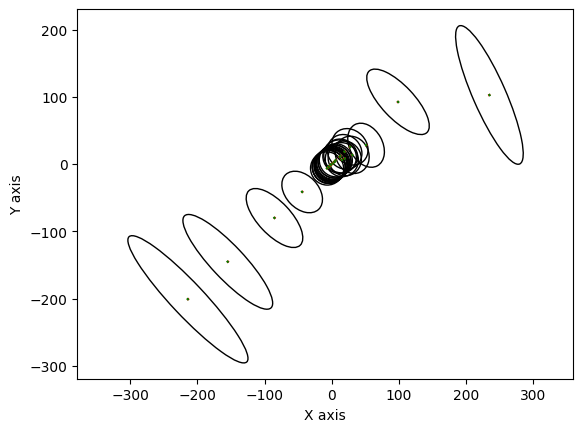

In [ ]:
import gtsam.utils.plot as gtsam_plot
for i in range(0, len(images)):
    gtsam_plot.plot_pose2(0, initial_estimate.atPose2(i), 0.5,
                          marginals_before.marginalCovariance(i))
plt.axis('equal'); plt.show()

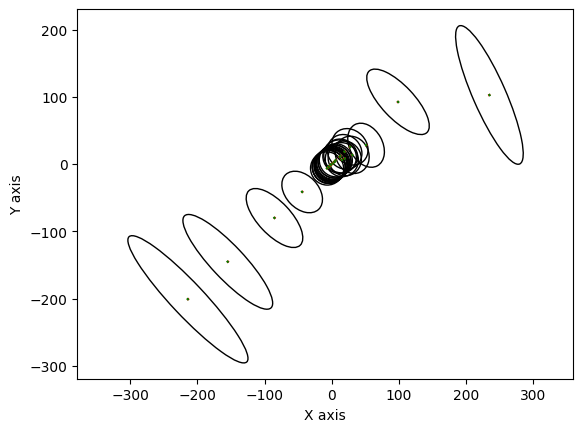

In [ ]:
for i in range(0, len(images)):
    gtsam_plot.plot_pose2(0, optimized_values.atPose2(i), 0.5,
                          marginals_after.marginalCovariance(i))
plt.axis('equal'); plt.show()

In [ ]:
import plotly.graph_objects as go
initial_poses = gtsam.utilities.extractPose2(initial_estimate)
fig = go.Figure()
fig.add_scatter(x=initial_poses[:,0], y=initial_poses[:,1], name="initial", marker=dict(color='orange'))
final_poses = gtsam.utilities.extractPose2(optimized_values)
fig.add_scatter(x=final_poses[:,0], y=final_poses[:,1], name="optimized", marker=dict(color='green'))
fig.update_yaxes(scaleanchor = "x",scaleratio = 1); fig.show()

In [ ]:
# Plot edges and vertices of each image with its covariance
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()): # For each vertex, plot the 2D pose with its covariance
        gtsam.utils.plot.plot_pose2(0, values.atPose2(vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]: # For each edge, get the keys and plot the start and end pose at those keys
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

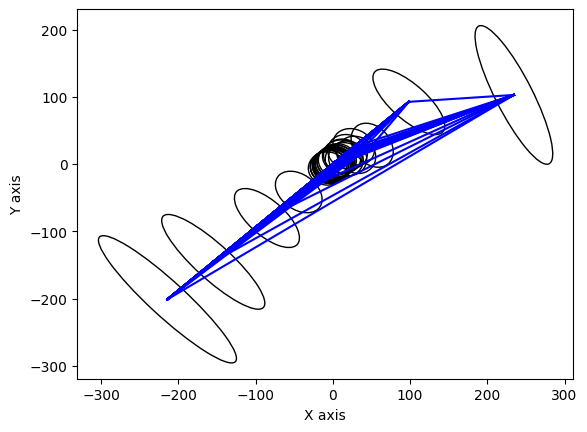

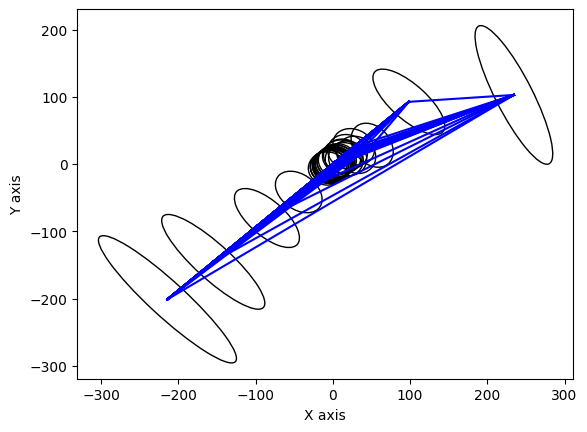

In [ ]:
# marginals = gtsam.Marginals(graph, initial_estimate)
plot_graph(initial_estimate, graph, marginals_before)
plot_graph(optimized_values, graph, marginals_after)

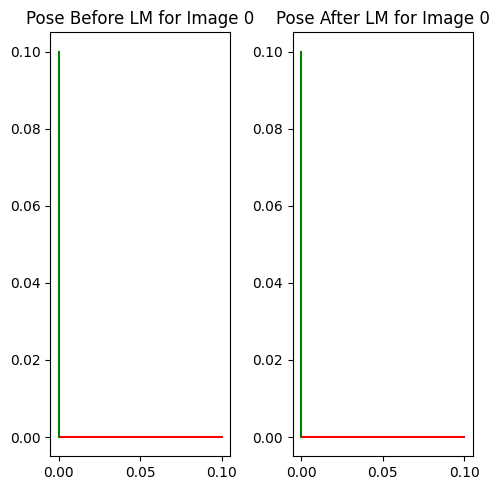

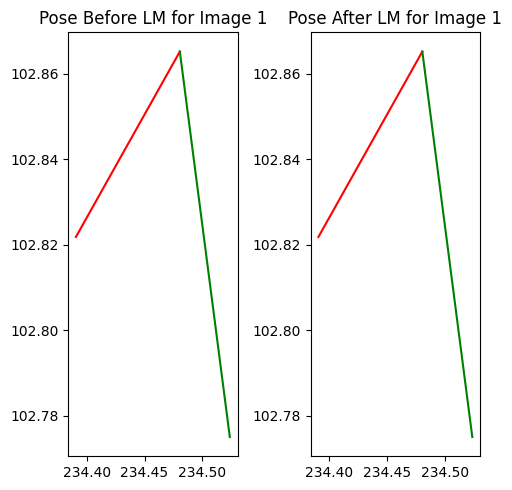

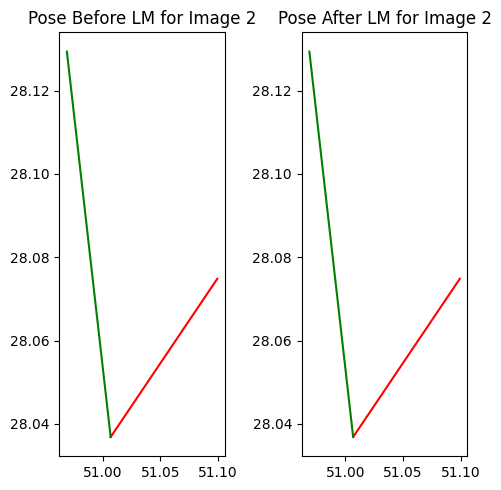

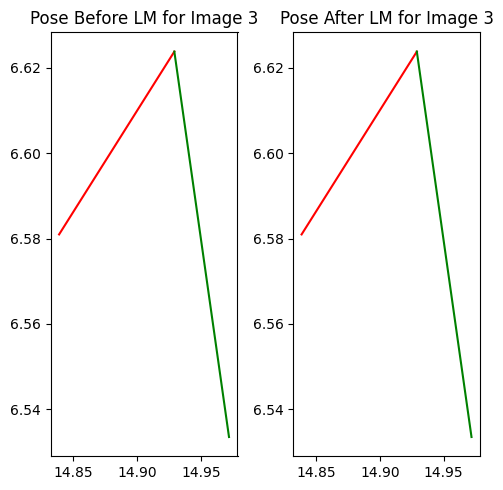

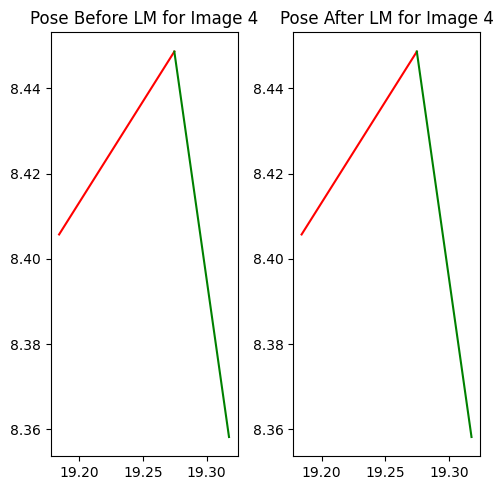

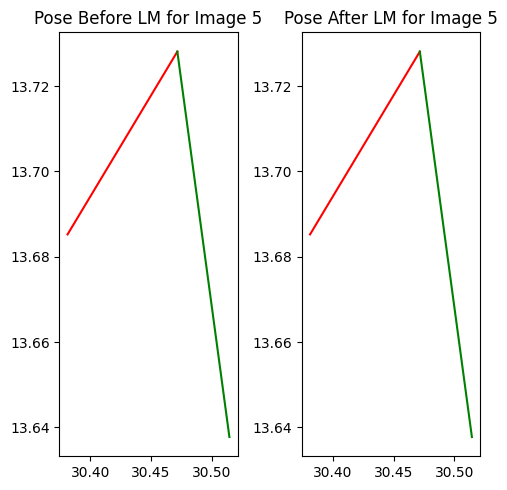

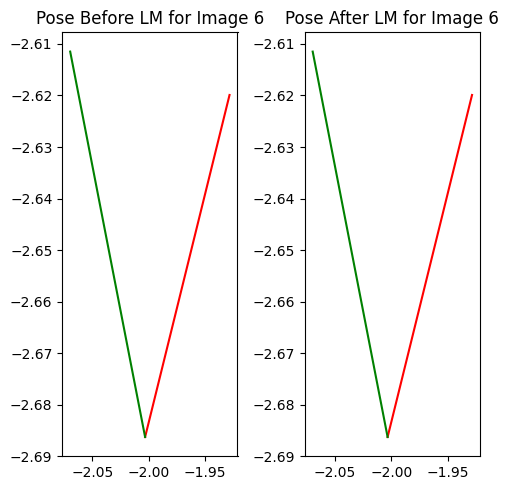

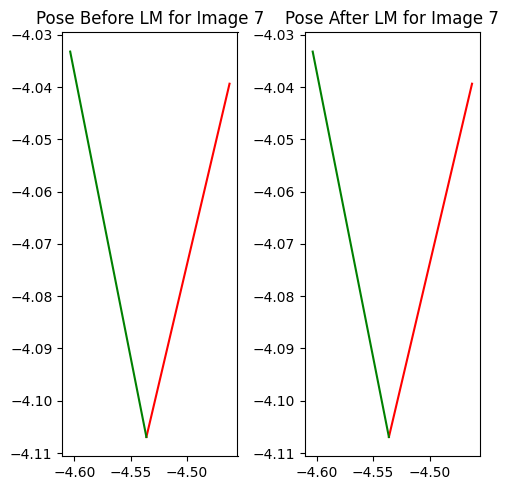

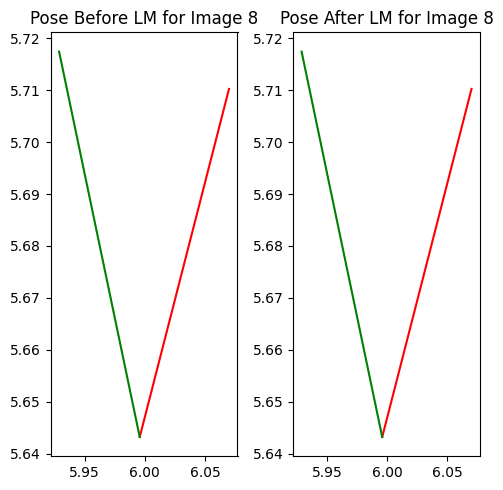

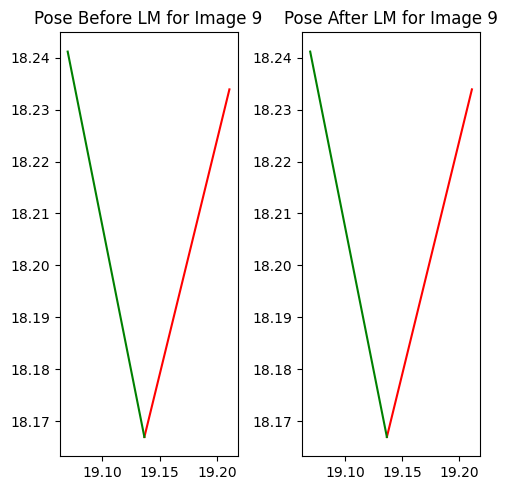

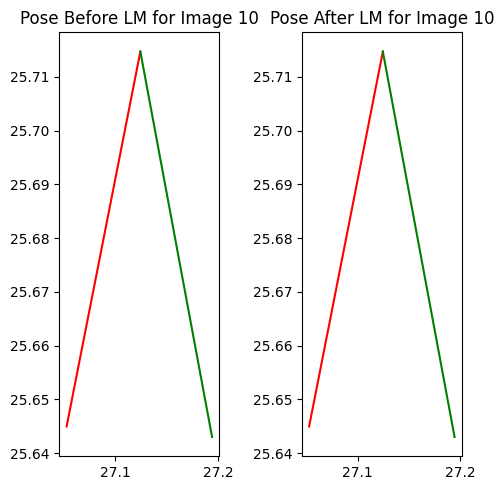

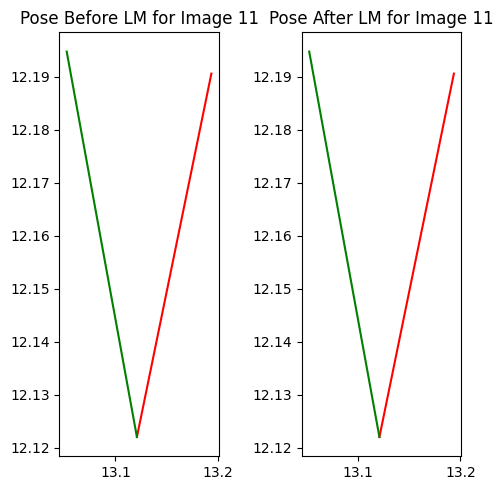

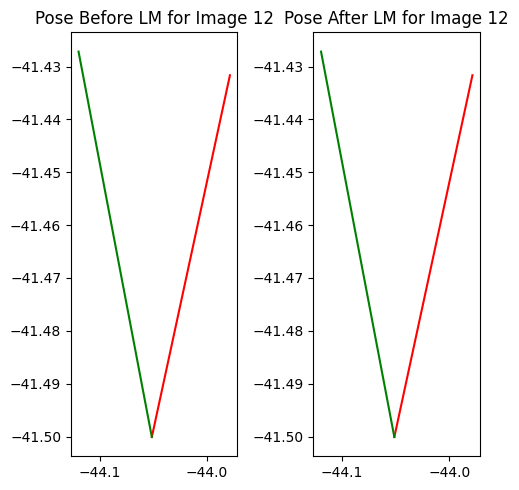

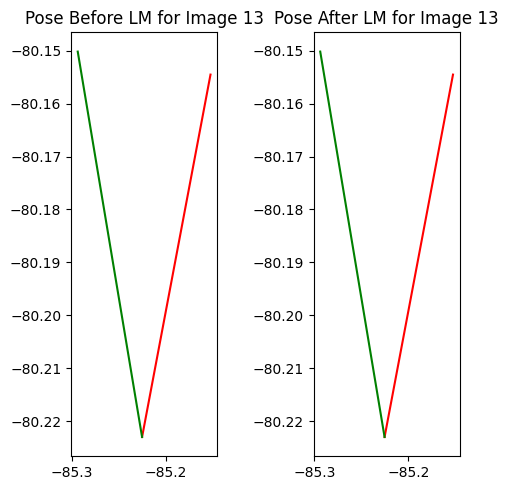

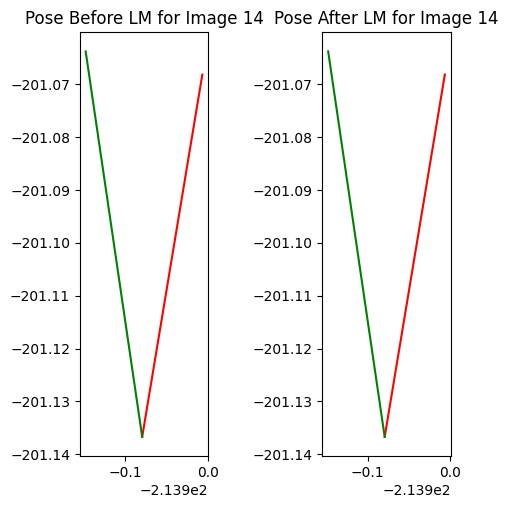

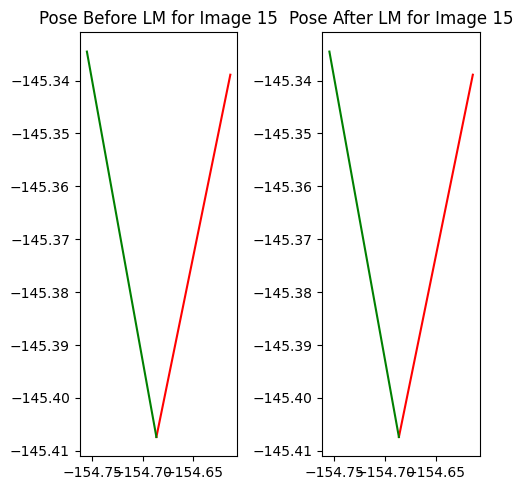

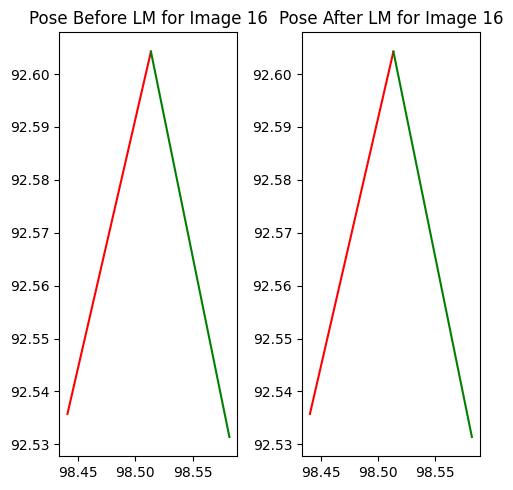

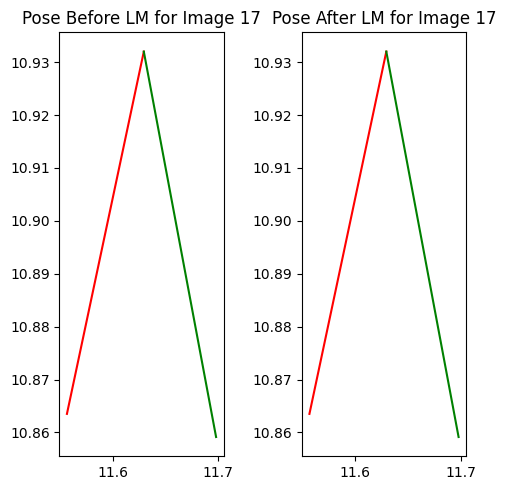

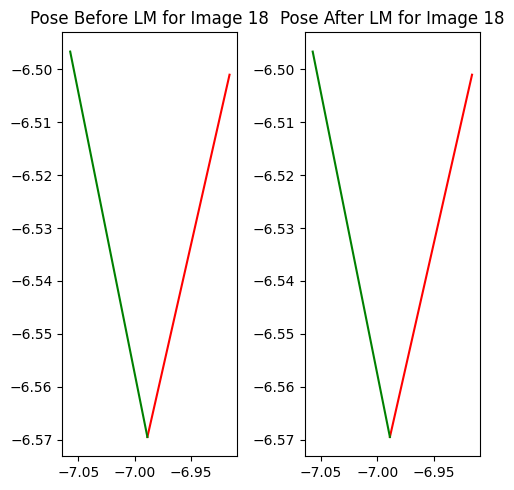

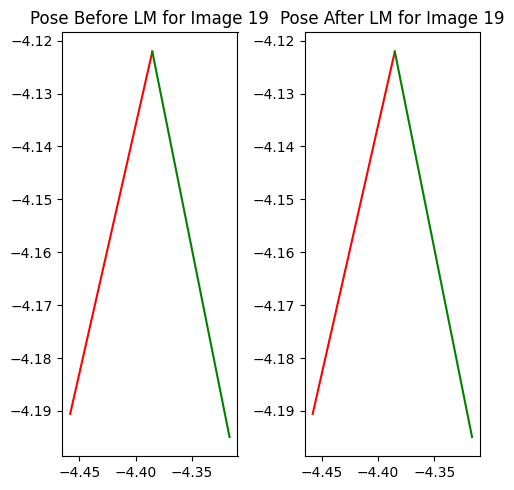

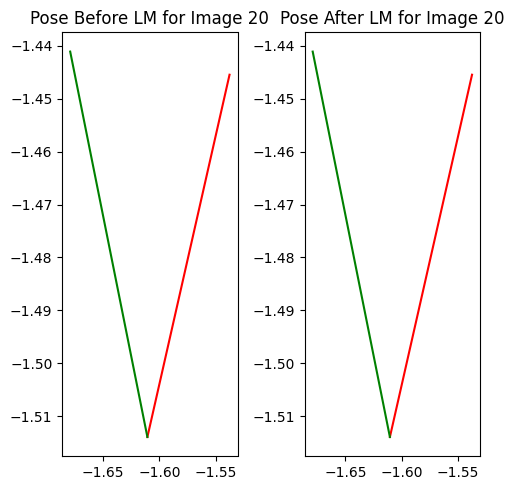

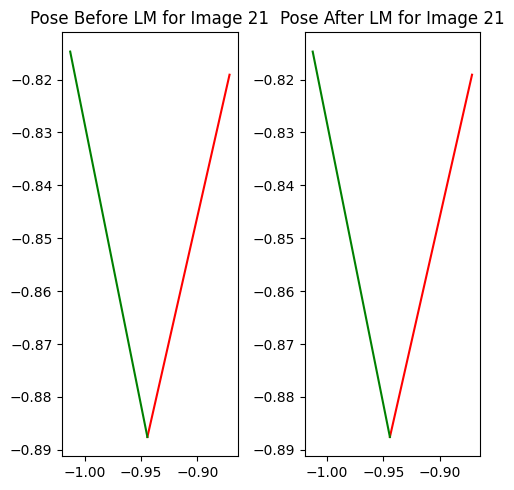

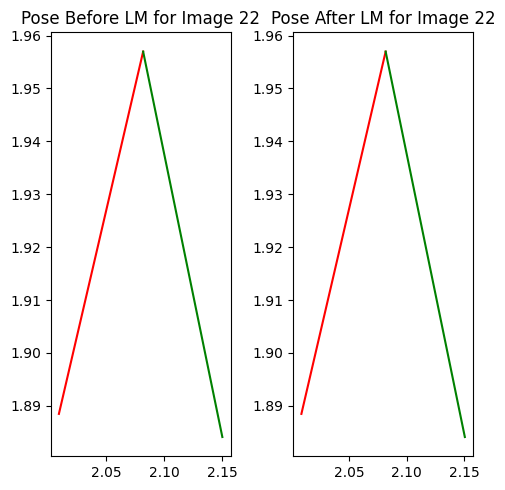

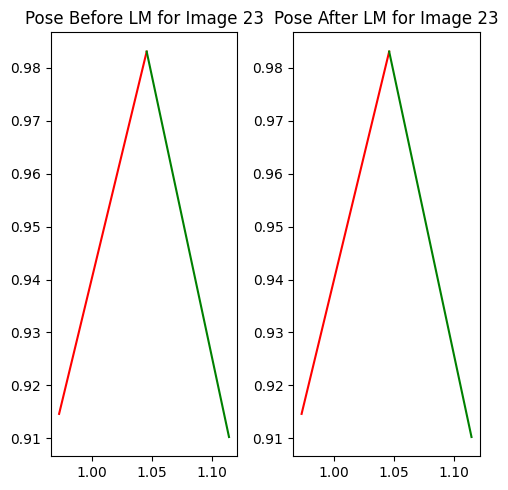

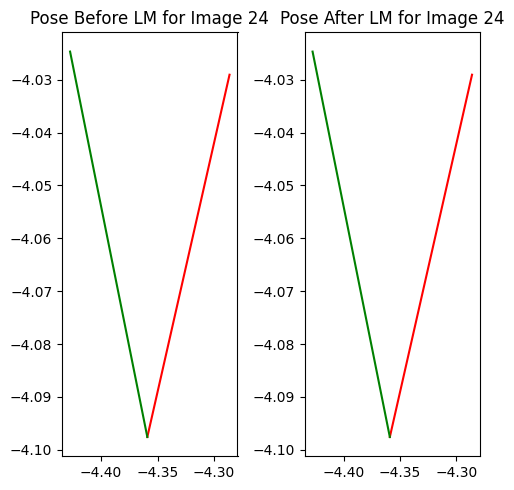

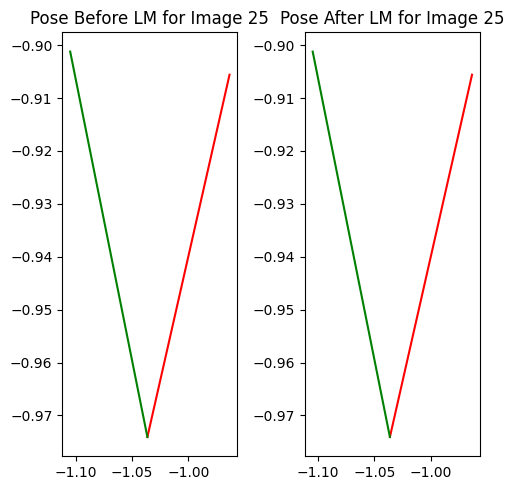

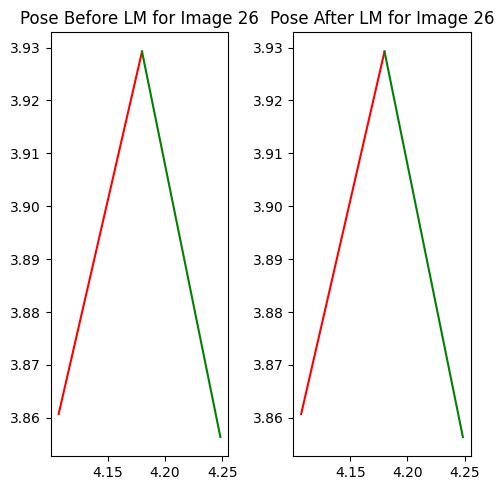

In [ ]:
# Plot the poses individually before and after LM optimization
for i, pose_before in enumerate(ori_poses):
    plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
    plt.subplot(121)  # Left subplot for before LM optimization
    plt.title(f'Pose Before LM for Image {i}')
    gtsam_plot.plot_pose2_on_axes(plt.gca(), pose_before, axis_length=0.1)  # Adjust axis_length as needed

    plt.subplot(122)  # Right subplot for after LM optimization
    plt.title(f'Pose After LM for Image {i}')
    gtsam_plot.plot_pose2_on_axes(plt.gca(), optimized_poses[i], axis_length=0.1)  # Adjust axis_length as needed

    plt.tight_layout()
    plt.show()